<a href="https://colab.research.google.com/github/PGM-Lab/2023-probai-private/blob/main/python/Day2-Evening/notebooks/students_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapt the variational auto encoder

Below you will find an implementation of a VAE for the MNIST data. To allow for faster learning time, we only consider the digits 0,1, and 2 and only the first 100 samples of those digits.

In this exercise, you should familiarize yourself with the implementation below and experiment with the structure of the VAE specification in order to emphasize digit separation in the latent space and the generation of images when sampling from the latent space.

Part of the implementation is based on code from the official Pyro examples.

In [1]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import datetime
import os
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import copy
import seaborn as sns
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Get the MNIST data


In [2]:
# For reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# By default, we only select the digits 5, 6, and 7 and only 100 examples from each of these
# digit classes
def get_data_sample(digits = [5,6,7], number_of_images_from_each_class = 100):

    _data = datasets.MNIST('./data', train=True, download=True)

    selector = np.array([], dtype=int)
    for i in digits:
        selector = np.concatenate((selector, np.random.choice(np.where(_data.targets == i)[0], 
                                                              size=number_of_images_from_each_class, replace=False)))

    _data.data = _data.data[selector, :, :]
    _data.targets = _data.targets[selector]

    # Binarize the data
    _data.data[_data.data<128] = 0
    _data.data[_data.data>=128] = 1

    _data.data = _data.data.type(torch.float)
    _data.data = _data.data.reshape(number_of_images_from_each_class*len(digits),-1)
    
    return _data, digits, number_of_images_from_each_class

data, digits, number_of_images_from_each_class = get_data_sample(number_of_images_from_each_class=100)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1441585.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 72177.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 284541.12it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2325504.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



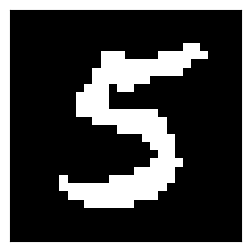

In [3]:
def display_image(x):
    plt.figure(figsize=(3,3))
    plt.imshow(x.reshape((28, 28)), cmap="gray")
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])


toy_image = data.data[0,:]
display_image(toy_image)

# Defining a VAE in Pyro

In the following implementation, the econder and decoder networks are provided as paramters to the VAE.

In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim, encoder, decoder):
        super(VAE, self).__init__()
        # set the encoder and decoder networks
        self.encoder = encoder
        self.decoder = decoder        
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(logits=loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    
    def sample_images(self, z, num_images = 5):
        if type(z) is not torch.Tensor: 
            z=torch.tensor(z, dtype=torch.float32)
   
        # Pass Z through the decoder network
        logits = self.decoder.forward(z)

        # Bernoulli distribution over images
        distribution_over_images = dist.Bernoulli(logits=logits)

        f, ax = plt.subplots(1, num_images+1, figsize=(10, 10), sharex=True)
        plt.axis('off')
        ax[0].imshow(distribution_over_images.mean.detach().numpy().reshape((28, 28)), cmap="gray")
        ax[0].set_xlabel('Mean of Distribution')
        for i in range(1, num_images+1):
          ax[i].imshow(distribution_over_images.sample().detach().numpy().reshape((28, 28)), cmap="gray")
          ax[i].set_xlabel('Sample '+str(i))
        plt.show()        
        
    def reconstruct_images(self, num_images=5):
        # Sample num_images randomly and (try) to reconstruct them.
        select_images_idx = np.random.choice(data.data.shape[0], size=num_images, replace=False)
        f, ax = plt.subplots(1, num_images, figsize=(10, 10))
        plt.tight_layout()
        # Display sampled images
        for idx, i in enumerate(select_images_idx):
            toy_image = data.data[i,:]
            ax[idx].imshow(toy_image.reshape(28,28), cmap="gray")    
            ax[idx].axes.get_xaxis().set_ticks([])
            ax[idx].axes.get_yaxis().set_ticks([])

        plt.show()
        # Display reconstructed images
        f, ax = plt.subplots(1, num_images, figsize=(10, 10))
        plt.tight_layout()
        for idx, i in enumerate(select_images_idx):
            toy_image = data.data[i,:]
            z_loc, _ = self.encoder(toy_image)
            logits_img = self.decoder(z_loc) 
            img_mean = dist.Bernoulli(logits=logits_img).mean
            ax[idx].imshow(img_mean.detach().numpy().reshape(28,28), cmap="gray")
            ax[idx].axes.get_xaxis().set_ticks([])
            ax[idx].axes.get_yaxis().set_ticks([])
        plt.show()   

# Defining the Encoder

Define a simple encoder with a single hidden layer

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.non_linearity = nn.ReLU()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.non_linearity(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale =nn.functional.softplus(self.fc22(hidden))
        return z_loc, z_scale

# Defining the Decoder

Define a linear decoder (i.e. a linear mapping) between the latent representation $z$ and the output space $x$

In [6]:
class LinearDecoder(nn.Module):
    def __init__(self, z_dim):
        super(LinearDecoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, 784)

    def forward(self, z):
        # define the forward computation on the latent z

        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        logits_img = self.fc1(z)

        return logits_img

# Training a VAE in Pyro

### Setup training (single epoch)

In [7]:
def train(svi, data):

    epoch_loss = svi.step(data)

    # return epoch loss
    normalizer_train = len(data)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

### Perform learning

[epoch 000] average training loss: 570.2750


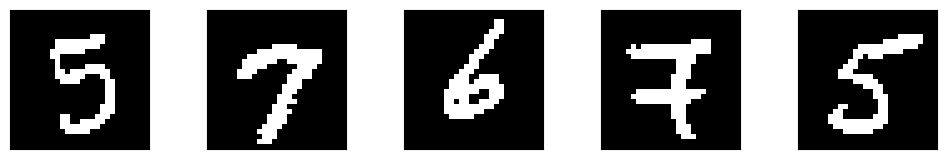

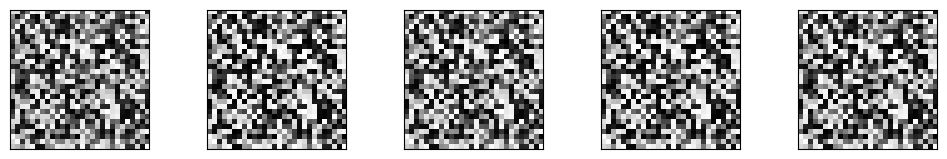

[epoch 100] average training loss: 224.9722
[epoch 200] average training loss: 211.0712
[epoch 300] average training loss: 199.6668
[epoch 400] average training loss: 194.0136
[epoch 500] average training loss: 189.6614


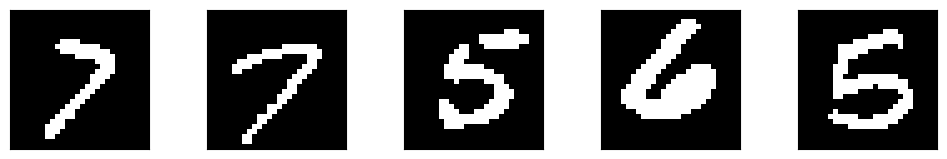

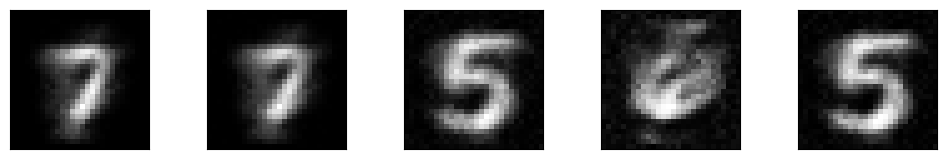

[epoch 600] average training loss: 186.2216
[epoch 700] average training loss: 183.5003
[epoch 800] average training loss: 181.3874
[epoch 900] average training loss: 179.6116


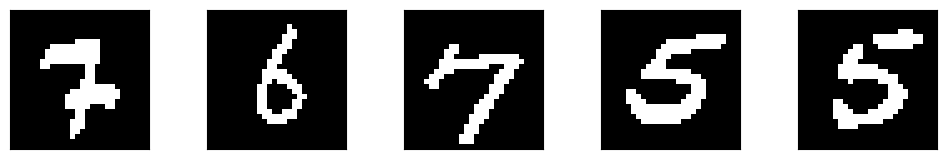

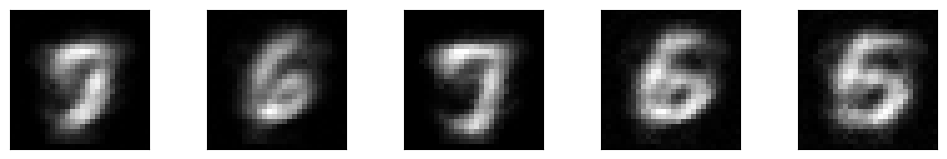

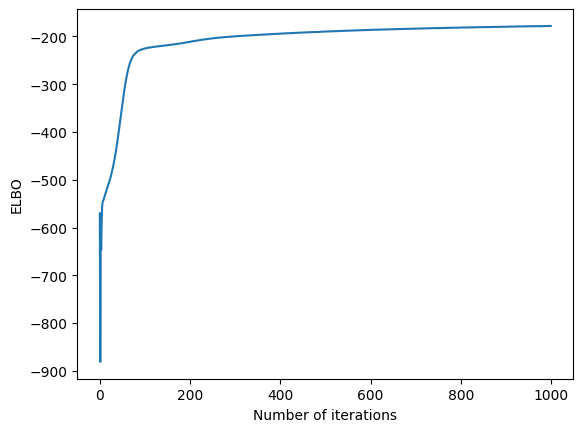

In [8]:
# Dimensionality of latent space
z_dim=2

# Define the variational autoencoder
vae = VAE(z_dim, encoder = Encoder(z_dim, hidden_dim=500), decoder = LinearDecoder(z_dim))

# Run options
LEARNING_RATE = 0.01

# Number of learning epochs
NUM_EPOCHS = 1000

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, data.data)
    train_elbo.append(-total_epoch_loss_train)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))    
    if (epoch % 500) == 0:
        vae.reconstruct_images()
vae.reconstruct_images()
plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()

# Explore the data in the latent space

Plot the representation of the data points in the latent space

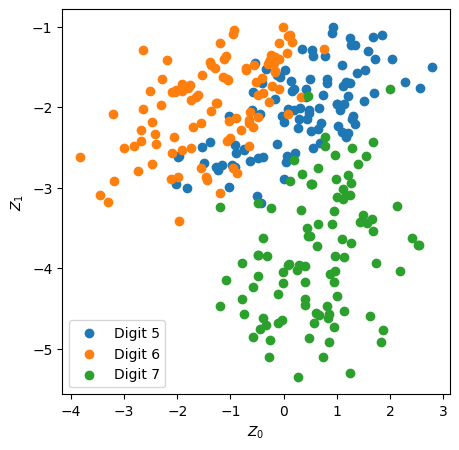

In [9]:
def plot_latent_representation(vae):
    """
    Plot latent representations of data
    """
    z_loc, z_scale = vae.encoder(data.data)
    legends = [f"Digit {i}" for i in digits]
    z_loc = z_loc.detach().numpy()

    plt.figure(figsize=(5,5))
    for idx, i in enumerate(digits):
        plt.scatter(z_loc[data.targets.numpy()==i,0], z_loc[data.targets.numpy()==i,1], label=legends[idx])

    plt.xlabel(r"$Z_0$")
    plt.ylabel(r"$Z_1$")
    plt.legend()
    plt.show()
    
plot_latent_representation(vae)

Partition the latent space and show the 'mean' image for each partition.

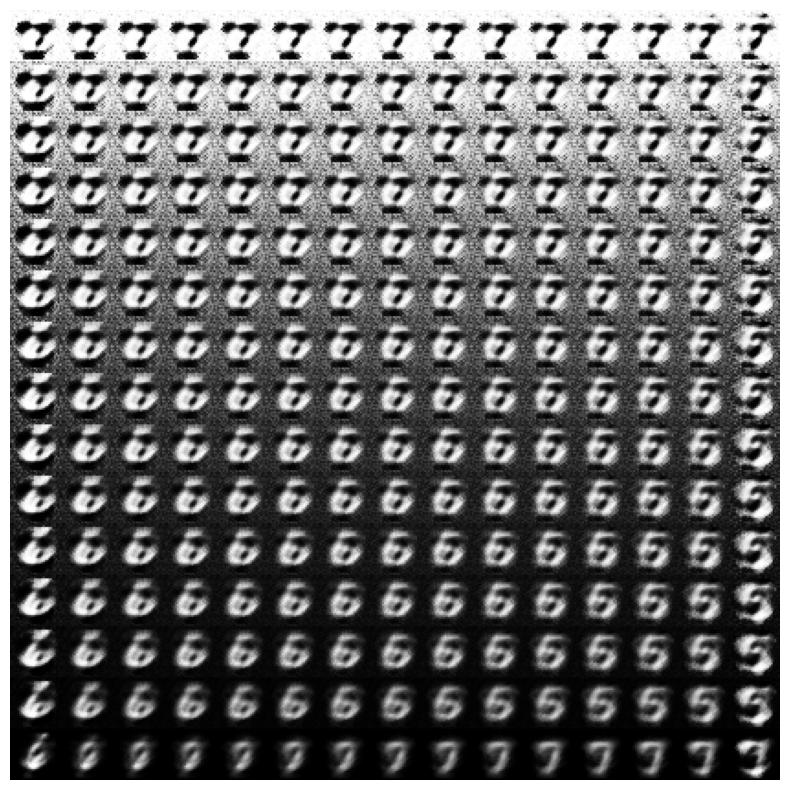

In [10]:
def plot_latent_space(vae: VAE, no_images: int = 15, img_size: int = 28):
    """
    Plot the latent space of the VAE
    """
    # Set up "target" z-values
    # linearly spaced coordinates on the unit square were transformed
    # through the inverse CDF (ppf) of the Gaussian to produce values
    # of the latent variables z, since the prior of the latent space
    # is Gaussian
    z1 = norm.ppf(np.linspace(0.001, 0.999, no_images))
    z2 = norm.ppf(np.linspace(0.999, 0.001, no_images)) # Flipped compared to z1 to make the figures comparable
    z_grid = np.dstack(np.meshgrid(z1, z2)).reshape(-1, 2)  # shape [no_images**2, z_dim]
    x_pred_grid = vae.decoder.forward(
        torch.tensor(z_grid, dtype=torch.float)
    ).detach().numpy().reshape(no_images, no_images, img_size, img_size)
    
    images = dist.Bernoulli(logits=torch.tensor(x_pred_grid)).mean.detach().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.block(list(map(list, images))), cmap='gray')
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.box(False)
    plt.show()
    
plot_latent_space(vae)

Show the posterior landscape of the latent space

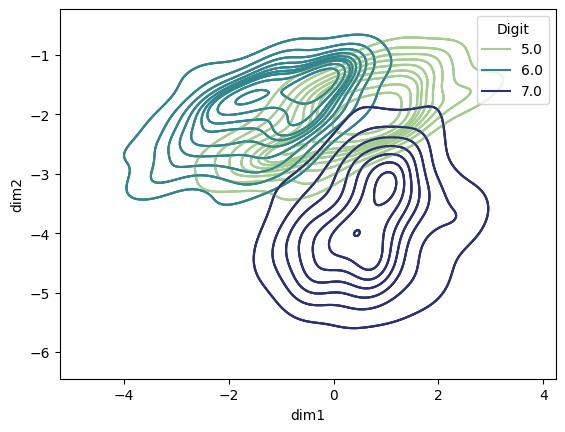

In [11]:
def plot_posterior(model):
    z_samples,_ = model.encoder(data.data)
    z_samples = z_samples.detach().numpy()
    z_class = data.targets.detach().numpy()

    for c in digits:
        sns.kdeplot(data=pd.DataFrame(np.hstack((z_samples,z_class.reshape(-1,1))), columns=["dim1", "dim2", "Digit"]), 
                    x="dim1", y="dim2", hue="Digit", palette="crest")  
    plt.show()

plot_posterior(vae)

# Exercise

1. Define as decoder network an MLP with one or more hidden layers and non-linear activation functions (e.g. Relu). 
    * You can also try to define a more expressive encoder network 
    * The number of hidden units should be parametrized.
    * You can adopt/complete the classes *FancyDecoder* and *FancyEncoder* defined below, finding inspiration in the classes *Encoder* and *LinearDecoder* given above.
2. Learn your newly defined VAE by adapting the code above. 
    * You may want to change the number of data points being used. A good starting point could be, e.g., 100 data points pr class while you experiment with the structure, but for getting more convincing visualization you may want to increase that to, say, 1000 data points pr. class
3. Explore the latent space (both the latent representation of the data points as well as the structure of the latent space). What happens when we increase the capacity of the non-linear decoder (i.e we increase the number of hidden units). 

### Candidate solution

In [12]:
class FancyDecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2):
        super(FancyDecoder, self).__init__()
        
        # Fill in the missing parts  
        # ...
        self.layer1 = nn.Linear(z_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)   
        self.layer3 = nn.Linear(hidden_dim2, 784)
        
        # Define the non-linearities
        self.non_linearity = nn.ReLU()
    
    def forward(self, z):

        # Fill in the missing parts  
        # ...
        hidden1 = self.non_linearity(self.layer1(z))
        hidden2 = self.non_linearity(self.layer2(hidden1))
        logits_img = self.layer3(hidden2)
        
        return logits_img

In [19]:
class FancyEncoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2):
        super(FancyEncoder, self).__init__()
 
        # Fill in the missing parts  
        # ...
        self.layer1 = nn.Linear(784, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer31 = nn.Linear(hidden_dim2, z_dim)
        self.layer32 = nn.Linear(hidden_dim2, z_dim)

        self.non_linearity = nn.ReLU()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        
        # Fill in the missing parts  
        # ...
        z1 = self.non_linearity(self.layer1(x))
        z2 = self.non_linearity(self.layer2(z1))
        
        z_loc = self.layer31(z2)
        z_scale = nn.functional.softplus(self.layer32(z2))
        
        return z_loc, z_scale

[epoch 000] average training loss: 542.8817


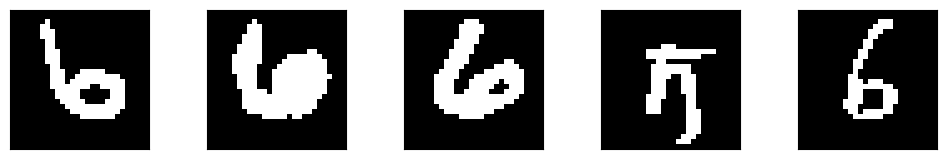

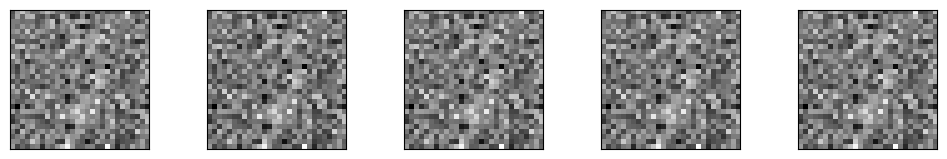

[epoch 100] average training loss: 185.3952
[epoch 200] average training loss: 146.9165
[epoch 300] average training loss: 136.2967
[epoch 400] average training loss: 130.7321
[epoch 500] average training loss: 125.9039


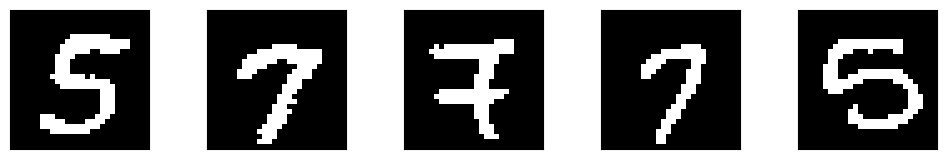

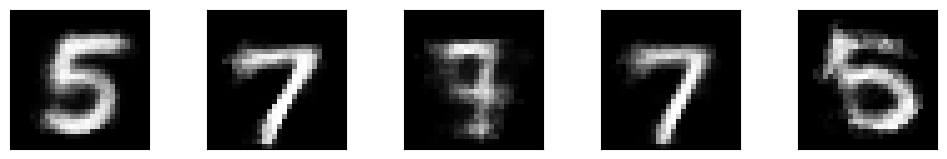

[epoch 600] average training loss: 120.4488
[epoch 700] average training loss: 115.9740
[epoch 800] average training loss: 112.4016
[epoch 900] average training loss: 109.2430


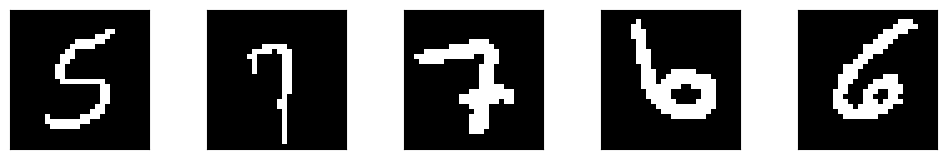

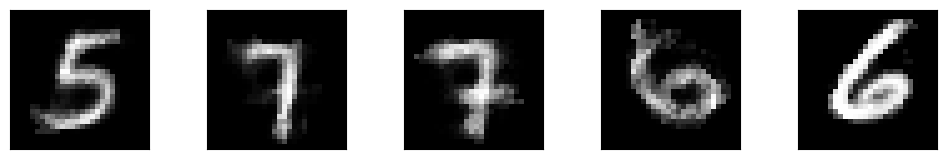

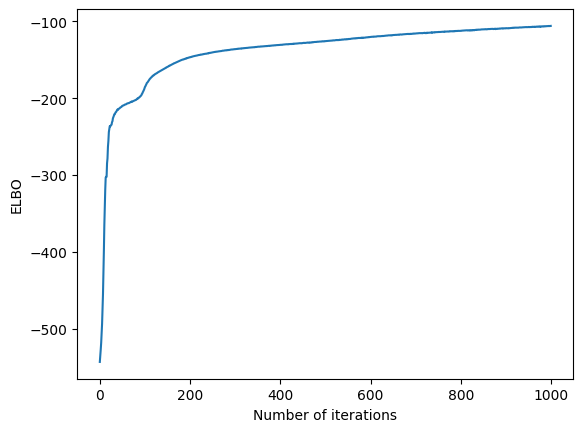

In [20]:
# Uncomment the following line if you want to play around with different data sets
#data, digits, number_of_images_from_each_class = get_data_sample(number_of_images_from_each_class = 1000)

z_dim=2

vae_non_linear = VAE(z_dim, encoder = FancyEncoder(z_dim, hidden_dim1 = 256, hidden_dim2 = 64), decoder = FancyDecoder(z_dim, hidden_dim1=64, hidden_dim2=256))

# Run options
LEARNING_RATE = 0.001

# Number of learning epochs
NUM_EPOCHS = 1000

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae_non_linear.model, vae_non_linear.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, data.data)
    train_elbo.append(-total_epoch_loss_train)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))
    
    if (epoch % 500) == 0:
        vae_non_linear.reconstruct_images()
vae_non_linear.reconstruct_images()

plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()

## Explore the latent space

Visualizing the data points in latent space

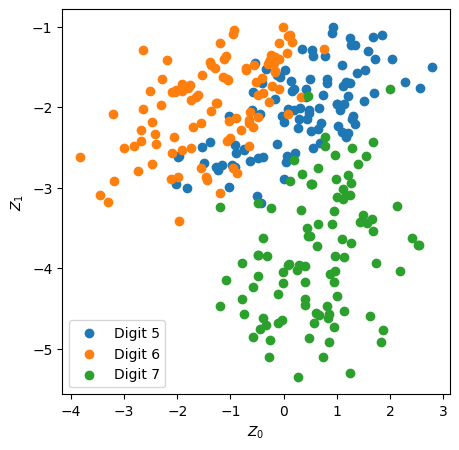

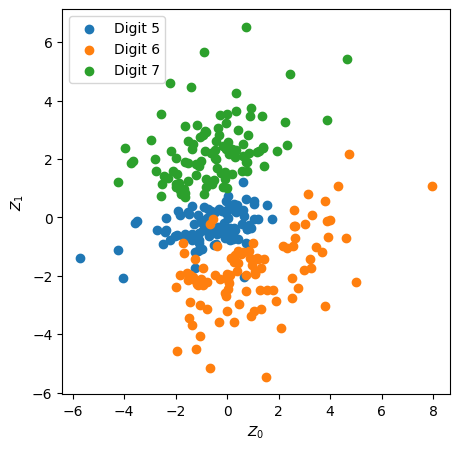

In [21]:
plot_latent_representation(vae)
plot_latent_representation(vae_non_linear)

Representation of the latent space. Linearly spaced coordinates on the unit sphere is mapped though the inverse of the inverse of the commulative density function of the Gaussian to find values $\boldsymbol z$ in latent space.

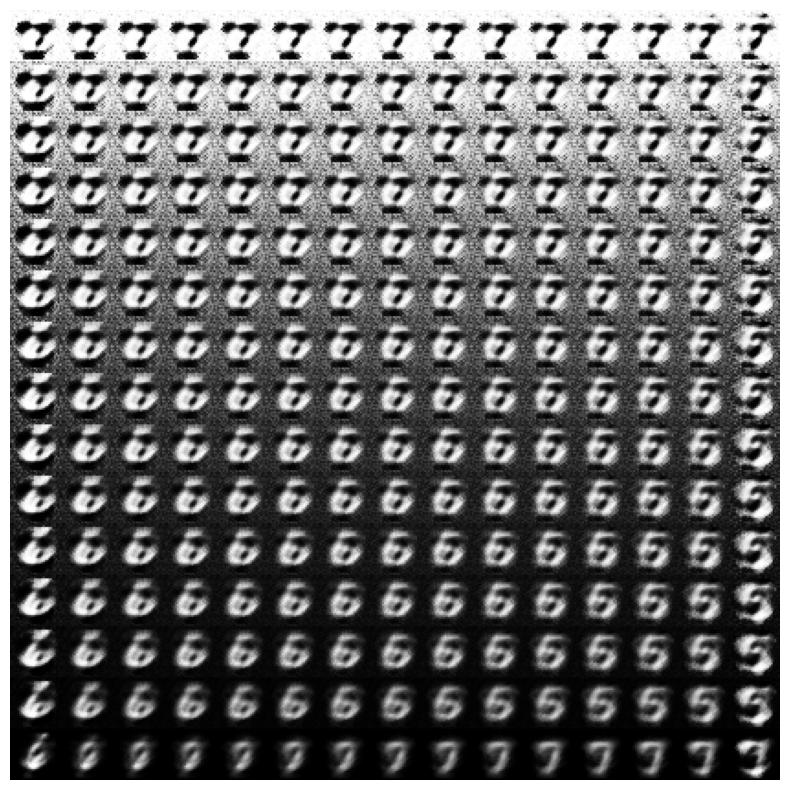

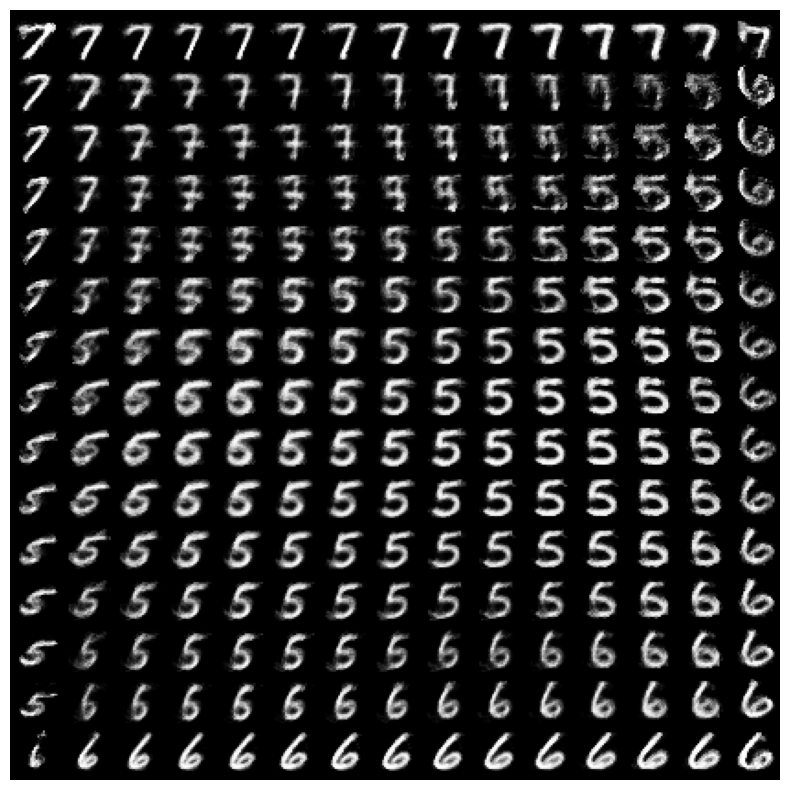

In [22]:
# Using the linear VAE
plot_latent_space(vae)
# Using the fancy VAE
plot_latent_space(vae_non_linear)

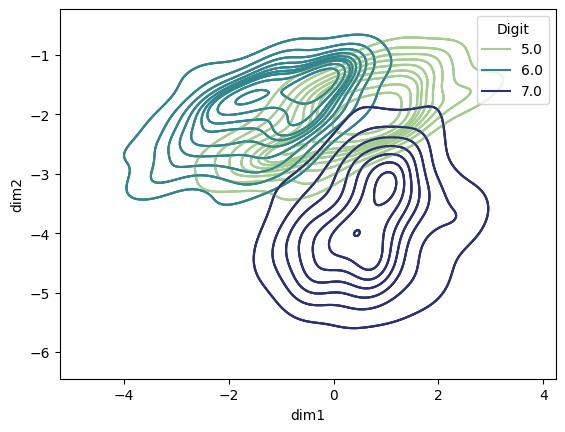

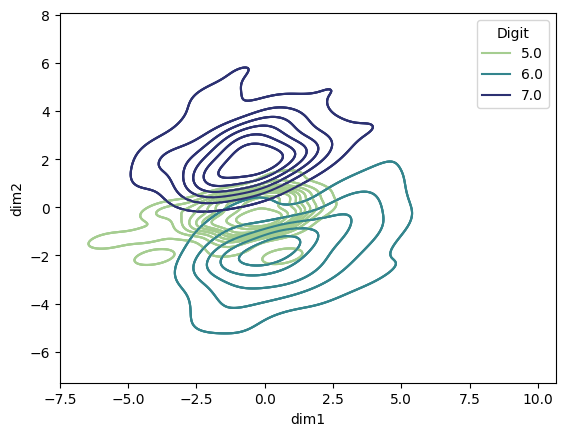

In [23]:
plot_posterior(vae)
plot_posterior(vae_non_linear)

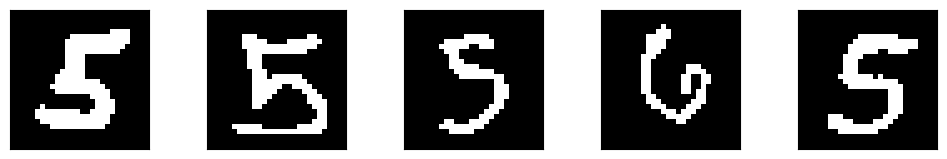

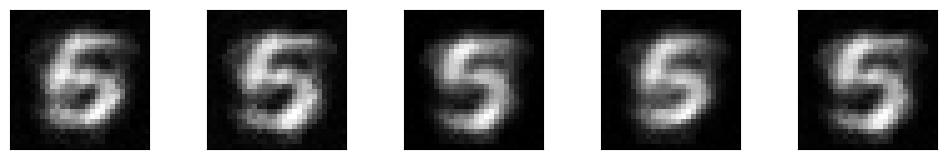

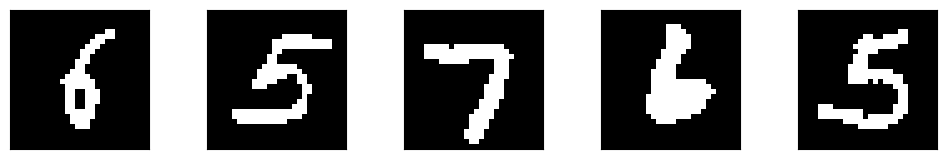

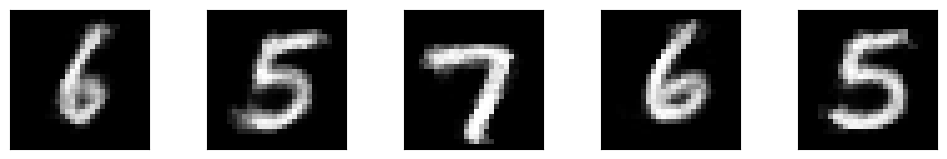

In [24]:
# Reconstruct images using the VAE
vae.reconstruct_images()
# Reconstruct images using the non-linear VAE
vae_non_linear.reconstruct_images()